In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPool2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, ELU
from keras.layers import Conv2D, LSTM, BatchNormalization, MaxPool2D, Reshape
from keras.utils import to_categorical
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [4]:
# cd drive/MyDrive/'Colab Notebooks'/CNN_Project/

(2115, 22, 1000)


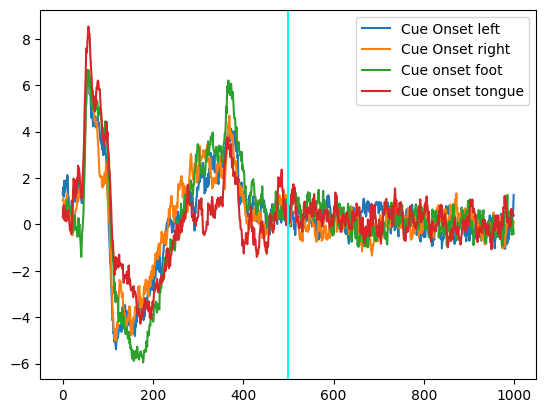

In [5]:
## Loading and visualizing the data

## Loading the dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that

# 2115 trials with each trial being a 22 x 1000 dimension data point
# Try to classify each movement by it's type/label (0, 1, 2, 3 - left, right, foot, tongue)
# Cue onset arm left - 0
# Cue onset arm right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

# Plotted for channel 8 of 22 channels
ch_data = X_train_valid[:,8,:]

class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)

class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

# Only using first 500 timesteps because from the chart we can see everything to the right
# of 500 looks like noise, while the left looks like better information
# Can also keep all 1000 if you want (optional preprocessing step)
# Too long of a time duration can be too much for RNN/LSTM, so it helps to reduce time duration

In [6]:
## Preprocessing the dataset
# ONLY TAKING FIRST 500 datapoints of the 1000
X_train_valid_prep_200 = X_train_valid[:,:,0:200]
X_test_prep_200 = X_test[:,:,0:200]

X_train_valid_prep_400 = X_train_valid[:,:,0:400]
X_test_prep_400 = X_test[:,:,0:400]

X_train_valid_prep_600 = X_train_valid[:,:,0:600]
X_test_prep_600 = X_test[:,:,0:600]

X_train_valid_prep_800 = X_train_valid[:,:,0:800]
X_test_prep_800 = X_test[:,:,0:800]

X_train_valid_prep_1000 = X_train_valid[:,:,0:1000]
X_test_prep_1000 = X_test[:,:,0:1000]

print(X_train_valid_prep_200.shape)
print(y_train_valid.shape)
print(X_test_prep_200.shape)
print(y_test.shape)


(2115, 22, 200)
(2115,)
(443, 22, 200)
(443,)


In [7]:
## Random splitting and reshaping the data

def shape_data(X_train_valid_prep, X_test_prep, y_train_valid, y_test):
    
    # 500 for validation, rest for training
    # First generating the training and validation indices using random splitting
    ind_valid = np.random.choice(2115, 500, replace=False)
    ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
    
    # Creating the training and validation sets using the generated indices
    (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
    # print('Shape of training set:',x_train.shape)
    # print('Shape of validation set:',x_valid.shape)
    # print('Shape of training labels:',y_train.shape)
    # print('Shape of validation labels:',y_valid.shape)
    
    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test, 4)
    # print('Shape of training labels after categorical conversion:',y_train.shape)
    # print('Shape of validation labels after categorical conversion:',y_valid.shape)
    # print('Shape of test labels after categorical conversion:',y_test.shape)
    
    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    # print('Shape of training set after adding width info:',x_train.shape)
    # print('Shape of validation set after adding width info:',x_valid.shape)
    # print('Shape of test set after adding width info:',x_test.shape)
    
    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    print('Shape of training set after dimension reshaping:',x_train.shape)
    print('Shape of validation set after dimension reshaping:',x_valid.shape)
    print('Shape of test set after dimension reshaping:',x_test.shape)

    return x_train, y_train, x_valid, y_valid, x_test, y_test


In [8]:
x_train_200, y_train_200, x_valid_200, y_valid_200, x_test_200, y_test_200 = shape_data(X_train_valid_prep_200, X_test_prep_200, y_train_valid, y_test)
x_train_400, y_train_400, x_valid_400, y_valid_400, x_test_400, y_test_400 = shape_data(X_train_valid_prep_400, X_test_prep_400, y_train_valid, y_test)
x_train_600, y_train_600, x_valid_600, y_valid_600, x_test_600, y_test_600 = shape_data(X_train_valid_prep_600, X_test_prep_600, y_train_valid, y_test)
x_train_800, y_train_800, x_valid_800, y_valid_800, x_test_800, y_test_800 = shape_data(X_train_valid_prep_800, X_test_prep_800, y_train_valid, y_test)
x_train_1000, y_train_1000, x_valid_1000, y_valid_1000, x_test_1000, y_test_1000 = shape_data(X_train_valid_prep_1000, X_test_prep_1000, y_train_valid, y_test)

Shape of training set after dimension reshaping: (1615, 200, 1, 22)
Shape of validation set after dimension reshaping: (500, 200, 1, 22)
Shape of test set after dimension reshaping: (443, 200, 1, 22)
Shape of training set after dimension reshaping: (1615, 400, 1, 22)
Shape of validation set after dimension reshaping: (500, 400, 1, 22)
Shape of test set after dimension reshaping: (443, 400, 1, 22)
Shape of training set after dimension reshaping: (1615, 600, 1, 22)
Shape of validation set after dimension reshaping: (500, 600, 1, 22)
Shape of test set after dimension reshaping: (443, 600, 1, 22)
Shape of training set after dimension reshaping: (1615, 800, 1, 22)
Shape of validation set after dimension reshaping: (500, 800, 1, 22)
Shape of test set after dimension reshaping: (443, 800, 1, 22)
Shape of training set after dimension reshaping: (1615, 1000, 1, 22)
Shape of validation set after dimension reshaping: (500, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 2

In [9]:
# Model Architecture
def hybrid_cnn_lstm_model(time_step):

    # Building the CNN/LSTM Hybrid model using sequential class
    hybrid_cnn_lstm_model = Sequential()
    
    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', kernel_regularizer=L1L2(l1=0, l2=0.015), activation='elu', input_shape=(time_step,1,22)))
    hybrid_cnn_lstm_model.add(MaxPool2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.55))
    
    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), kernel_regularizer=L1L2(l1=0, l2=0.015), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPool2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.55))
    
    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), kernel_regularizer=L1L2(l1=0, l2=0.015), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPool2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.55))
    
    # Conv. block 4
    hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), kernel_regularizer=L1L2(l1=0, l2=0.015), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPool2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.55))
    
    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
    hybrid_cnn_lstm_model.add(LSTM(30, dropout=0.50, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))
    
    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
    
    # Printing the model summary
    hybrid_cnn_lstm_model.summary()

    return hybrid_cnn_lstm_model


## Timestep 0 - 200

In [10]:
# Model parameters 
hybrid_cnn_lstm_model_200 = hybrid_cnn_lstm_model(200)
learning_rate = 0.00075
epochs = 150
cnn_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2  (None, 67, 1, 25)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 67, 1, 25)         100       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 67, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 1, 50)         12550     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 1, 50)         0

In [11]:
# Compiling the model 
hybrid_cnn_lstm_model_200.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_200_results = hybrid_cnn_lstm_model_200.fit(x_train_200,
             y_train_200,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_200, y_valid_200), verbose=True)

Epoch 1/150
26/26 [==============================] - 2s 37ms/step - loss: 4.6218 - accuracy: 0.2824 - val_loss: 4.0136 - val_accuracy: 0.2400
Epoch 2/150
26/26 [==============================] - 1s 30ms/step - loss: 3.5777 - accuracy: 0.2712 - val_loss: 3.1514 - val_accuracy: 0.2760
Epoch 3/150
26/26 [==============================] - 1s 30ms/step - loss: 2.8851 - accuracy: 0.3028 - val_loss: 2.6402 - val_accuracy: 0.3040
Epoch 4/150
26/26 [==============================] - 1s 31ms/step - loss: 2.4936 - accuracy: 0.3257 - val_loss: 2.3711 - val_accuracy: 0.2660
Epoch 5/150
26/26 [==============================] - 1s 31ms/step - loss: 2.2620 - accuracy: 0.3096 - val_loss: 2.1687 - val_accuracy: 0.2800
Epoch 6/150
26/26 [==============================] - 1s 31ms/step - loss: 2.0752 - accuracy: 0.3269 - val_loss: 2.0225 - val_accuracy: 0.2820
Epoch 7/150
26/26 [==============================] - 1s 31ms/step - loss: 1.9585 - accuracy: 0.3245 - val_loss: 1.9551 - val_accuracy: 0.2460
Epoch 

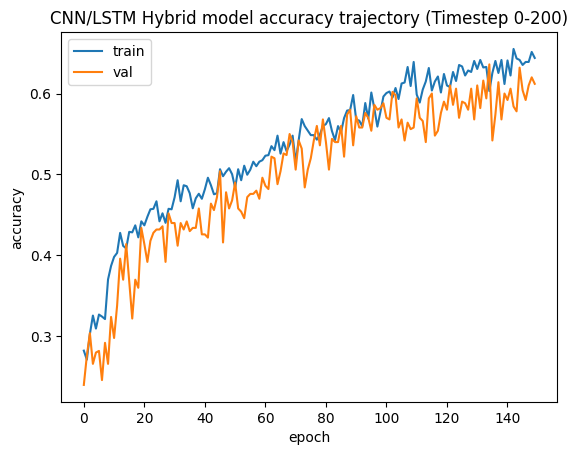

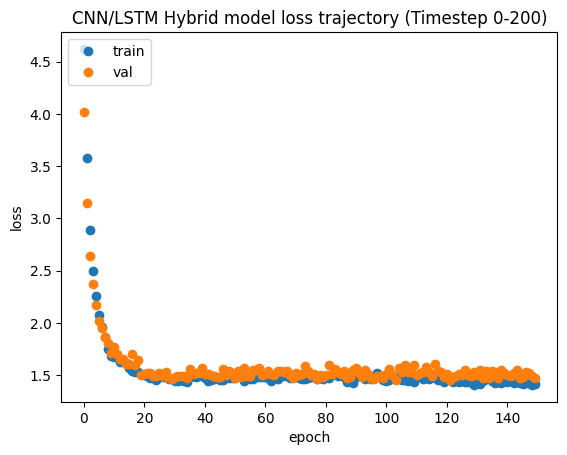

In [12]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_200_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_200_results.history['val_accuracy'])
plt.title('CNN/LSTM Hybrid model accuracy trajectory (Timestep 0-200)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_200_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_200_results.history['val_loss'],'o')
plt.title('CNN/LSTM Hybrid model loss trajectory (Timestep 0-200)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
## Testing the basic CNN model - using the model from the last epoch (Must get 70% or higher for full credit)
hybrid_cnn_lstm_200_score = hybrid_cnn_lstm_model_200.evaluate(x_test_200, y_test_200, verbose=0)
print('Test accuracy of the basic CNN model:',hybrid_cnn_lstm_200_score[1])

Test accuracy of the basic CNN model: 0.5936794877052307


This is a reasonabley well performing model, the validation accuracy (orange) is closely following the training accuracy (blue), so the model is not overfitting. Similar for the loss plot, the validation(orange) is following closely with the training loss (blue) and seems to be converging (going toward zero), may be better to train for more epochs to see further convergence.

U shaped curve for the loss means we are overfitting.

## Timestep 0 - 400

In [14]:
# Model parameters 
hybrid_cnn_lstm_model_400 = hybrid_cnn_lstm_model(400)
learning_rate = 0.00075
epochs = 150
cnn_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 400, 1, 25)        5525      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 134, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 134, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 134, 1, 25)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 134, 1, 50)        12550     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 1, 50)        

In [15]:
# Compiling the model 
hybrid_cnn_lstm_model_400.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_400_results = hybrid_cnn_lstm_model_400.fit(x_train_400,
             y_train_400,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_400, y_valid_400), verbose=True)

Epoch 1/150
26/26 [==============================] - 3s 74ms/step - loss: 4.6097 - accuracy: 0.2526 - val_loss: 3.9267 - val_accuracy: 0.3240
Epoch 2/150
26/26 [==============================] - 2s 63ms/step - loss: 3.4970 - accuracy: 0.2935 - val_loss: 3.0933 - val_accuracy: 0.2880
Epoch 3/150
26/26 [==============================] - 2s 63ms/step - loss: 2.8538 - accuracy: 0.3331 - val_loss: 2.6399 - val_accuracy: 0.3020
Epoch 4/150
26/26 [==============================] - 2s 65ms/step - loss: 2.4834 - accuracy: 0.3517 - val_loss: 2.4139 - val_accuracy: 0.2880
Epoch 5/150
26/26 [==============================] - 2s 64ms/step - loss: 2.2787 - accuracy: 0.3678 - val_loss: 2.2366 - val_accuracy: 0.3000
Epoch 6/150
26/26 [==============================] - 2s 63ms/step - loss: 2.1048 - accuracy: 0.3938 - val_loss: 2.1100 - val_accuracy: 0.3240
Epoch 7/150
26/26 [==============================] - 2s 65ms/step - loss: 1.9685 - accuracy: 0.4149 - val_loss: 2.0500 - val_accuracy: 0.2920
Epoch 

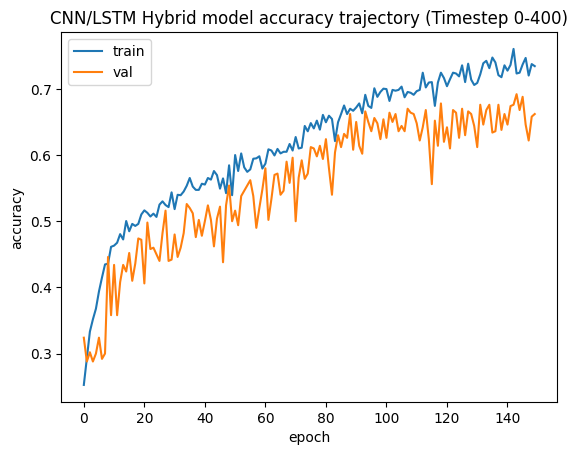

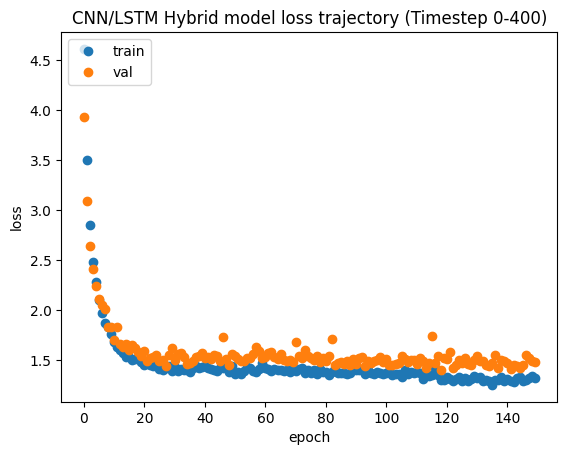

In [16]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_400_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_400_results.history['val_accuracy'])
plt.title('CNN/LSTM Hybrid model accuracy trajectory (Timestep 0-400)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_400_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_400_results.history['val_loss'],'o')
plt.title('CNN/LSTM Hybrid model loss trajectory (Timestep 0-400)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
## Testing the basic CNN model - using the model from the last epoch (Must get 70% or higher for full credit)
hybrid_cnn_lstm_400_score = hybrid_cnn_lstm_model_400.evaluate(x_test_400, y_test_400, verbose=0)
print('Test accuracy of the basic CNN model:', hybrid_cnn_lstm_400_score[1])

Test accuracy of the basic CNN model: 0.6546275615692139


## Timestep 0 - 600

In [18]:
# Model parameters 
hybrid_cnn_lstm_model_600 = hybrid_cnn_lstm_model(600)
learning_rate = 0.00075
epochs = 150
cnn_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 600, 1, 25)        5525      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 200, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 200, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 200, 1, 25)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 200, 1, 50)        12550     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 67, 1, 50)        

In [19]:
# Compiling the model 
hybrid_cnn_lstm_model_600.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_600_results = hybrid_cnn_lstm_model_600.fit(x_train_600,
             y_train_600,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_600, y_valid_600), verbose=True)

Epoch 1/150
26/26 [==============================] - 3s 65ms/step - loss: 4.5107 - accuracy: 0.2836 - val_loss: 3.8228 - val_accuracy: 0.2600
Epoch 2/150
26/26 [==============================] - 2s 59ms/step - loss: 3.3796 - accuracy: 0.3046 - val_loss: 2.9676 - val_accuracy: 0.3400
Epoch 3/150
26/26 [==============================] - 1s 58ms/step - loss: 2.7468 - accuracy: 0.3399 - val_loss: 2.5161 - val_accuracy: 0.3580
Epoch 4/150
26/26 [==============================] - 2s 59ms/step - loss: 2.3773 - accuracy: 0.3814 - val_loss: 2.2358 - val_accuracy: 0.4260
Epoch 5/150
26/26 [==============================] - 2s 61ms/step - loss: 2.1641 - accuracy: 0.4050 - val_loss: 2.0952 - val_accuracy: 0.3960
Epoch 6/150
26/26 [==============================] - 2s 62ms/step - loss: 2.0356 - accuracy: 0.4303 - val_loss: 1.9663 - val_accuracy: 0.4600
Epoch 7/150
26/26 [==============================] - 2s 62ms/step - loss: 1.9382 - accuracy: 0.4322 - val_loss: 1.9139 - val_accuracy: 0.4180
Epoch 

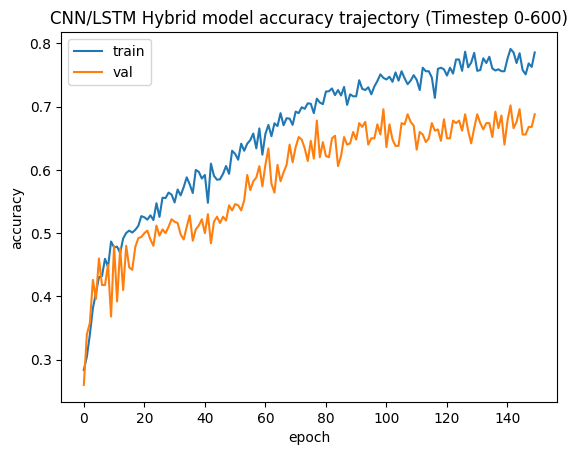

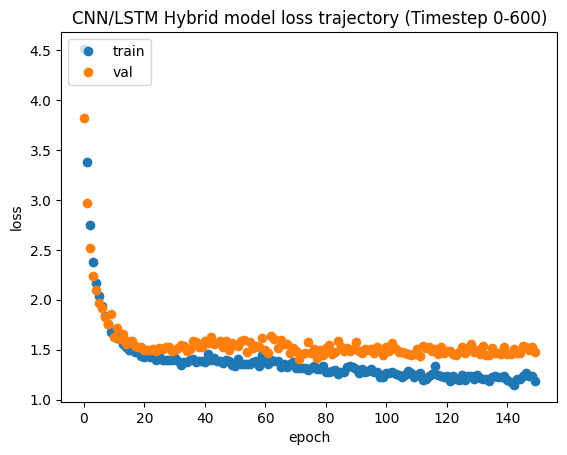

In [20]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_600_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_600_results.history['val_accuracy'])
plt.title('CNN/LSTM Hybrid model accuracy trajectory (Timestep 0-600)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_600_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_600_results.history['val_loss'],'o')
plt.title('CNN/LSTM Hybrid model loss trajectory (Timestep 0-600)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
## Testing the basic CNN model - using the model from the last epoch (Must get 70% or higher for full credit)
hybrid_cnn_lstm_600_score = hybrid_cnn_lstm_model_600.evaluate(x_test_600, y_test_600, verbose=0)
print('Test accuracy of the basic CNN model:',hybrid_cnn_lstm_600_score[1])

Test accuracy of the basic CNN model: 0.6862302422523499


## Timestep 0 - 800

In [22]:
# Model parameters 
hybrid_cnn_lstm_model_800 = hybrid_cnn_lstm_model(800)
learning_rate = 0.00075
epochs = 150
cnn_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 800, 1, 25)        5525      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 267, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 267, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 267, 1, 25)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 267, 1, 50)        12550     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 89, 1, 50)        

In [23]:
# Compiling the model 
hybrid_cnn_lstm_model_800.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_800_results = hybrid_cnn_lstm_model_800.fit(x_train_800,
             y_train_800,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_800, y_valid_800), verbose=True)

Epoch 1/150
26/26 [==============================] - 3s 75ms/step - loss: 4.7356 - accuracy: 0.2483 - val_loss: 4.1347 - val_accuracy: 0.2800
Epoch 2/150
26/26 [==============================] - 2s 67ms/step - loss: 3.7114 - accuracy: 0.3009 - val_loss: 3.2820 - val_accuracy: 0.3140
Epoch 3/150
26/26 [==============================] - 2s 66ms/step - loss: 2.9985 - accuracy: 0.3207 - val_loss: 2.7292 - val_accuracy: 0.3300
Epoch 4/150
26/26 [==============================] - 2s 67ms/step - loss: 2.5563 - accuracy: 0.3505 - val_loss: 2.4273 - val_accuracy: 0.3000
Epoch 5/150
26/26 [==============================] - 2s 68ms/step - loss: 2.2962 - accuracy: 0.3591 - val_loss: 2.2031 - val_accuracy: 0.3640
Epoch 6/150
26/26 [==============================] - 2s 68ms/step - loss: 2.1148 - accuracy: 0.3889 - val_loss: 2.0805 - val_accuracy: 0.3640
Epoch 7/150
26/26 [==============================] - 2s 69ms/step - loss: 1.9918 - accuracy: 0.4130 - val_loss: 1.9861 - val_accuracy: 0.3660
Epoch 

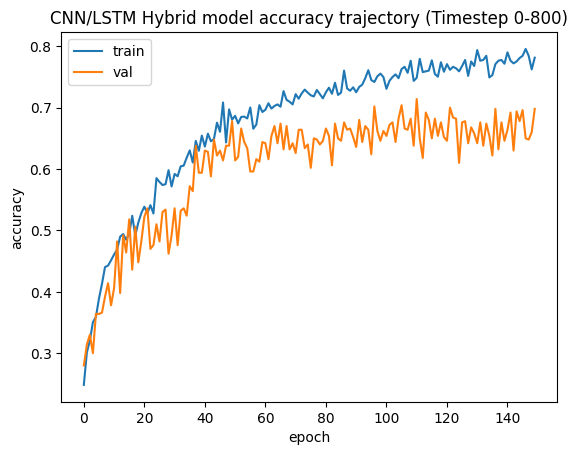

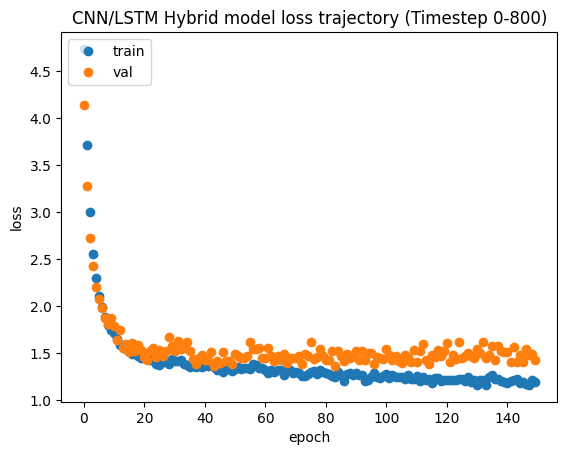

In [24]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_800_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_800_results.history['val_accuracy'])
plt.title('CNN/LSTM Hybrid model accuracy trajectory (Timestep 0-800)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_800_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_800_results.history['val_loss'],'o')
plt.title('CNN/LSTM Hybrid model loss trajectory (Timestep 0-800)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
## Testing the basic CNN model - using the model from the last epoch (Must get 70% or higher for full credit)
hybrid_cnn_lstm_800_score = hybrid_cnn_lstm_model_800.evaluate(x_test_800, y_test_800, verbose=0)
print('Test accuracy of the basic CNN model:',hybrid_cnn_lstm_800_score[1])

Test accuracy of the basic CNN model: 0.6478555202484131


## Timestep 0 - 1000

In [26]:
# Model parameters 
hybrid_cnn_lstm_model_1000 = hybrid_cnn_lstm_model(1000)
learning_rate = 0.00075
epochs = 150
cnn_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 1000, 1, 25)       5525      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 334, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_16 (Ba  (None, 334, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 334, 1, 25)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 334, 1, 50)        12550     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 112, 1, 50)       

In [27]:
# Compiling the model 
hybrid_cnn_lstm_model_1000.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_1000_results = hybrid_cnn_lstm_model_1000.fit(x_train_1000,
             y_train_1000,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_1000, y_valid_1000), verbose=True)

Epoch 1/150
26/26 [==============================] - 3s 87ms/step - loss: 4.2520 - accuracy: 0.2638 - val_loss: 3.3690 - val_accuracy: 0.2600
Epoch 2/150
26/26 [==============================] - 2s 79ms/step - loss: 2.9305 - accuracy: 0.2786 - val_loss: 2.5389 - val_accuracy: 0.2940
Epoch 3/150
26/26 [==============================] - 2s 81ms/step - loss: 2.3444 - accuracy: 0.2873 - val_loss: 2.1641 - val_accuracy: 0.2620
Epoch 4/150
26/26 [==============================] - 2s 82ms/step - loss: 2.0446 - accuracy: 0.3245 - val_loss: 1.9737 - val_accuracy: 0.2420
Epoch 5/150
26/26 [==============================] - 2s 84ms/step - loss: 1.8991 - accuracy: 0.3560 - val_loss: 1.9076 - val_accuracy: 0.2240
Epoch 6/150
26/26 [==============================] - 2s 83ms/step - loss: 1.7969 - accuracy: 0.3591 - val_loss: 1.8542 - val_accuracy: 0.2720
Epoch 7/150
26/26 [==============================] - 2s 84ms/step - loss: 1.7015 - accuracy: 0.3864 - val_loss: 1.6927 - val_accuracy: 0.3500
Epoch 

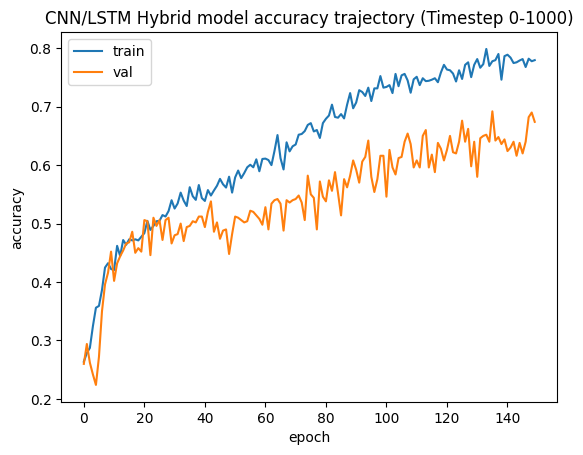

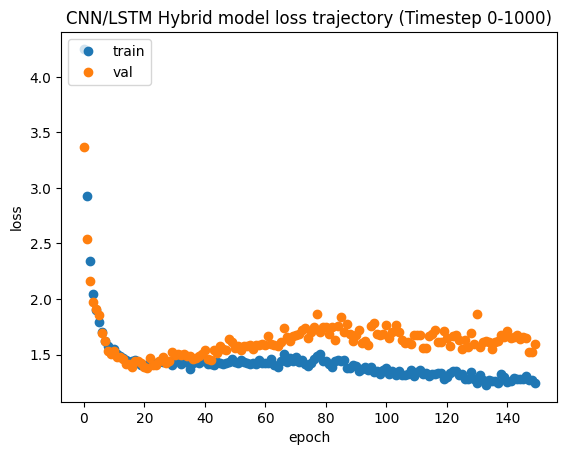

In [28]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_1000_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_1000_results.history['val_accuracy'])
plt.title('CNN/LSTM Hybrid model accuracy trajectory (Timestep 0-1000)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_1000_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_1000_results.history['val_loss'],'o')
plt.title('CNN/LSTM Hybrid model loss trajectory (Timestep 0-1000)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
## Testing the basic CNN model - using the model from the last epoch (Must get 70% or higher for full credit)
hybrid_cnn_lstm_1000_score = hybrid_cnn_lstm_model_1000.evaluate(x_test_1000, y_test_1000, verbose=0)
print('Test accuracy of the basic CNN model:',hybrid_cnn_lstm_1000_score[1])

Test accuracy of the basic CNN model: 0.6478555202484131
